In [317]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 

In [318]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [319]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

import wandb

wandb.init(project="dacon-painter", entity="kimjunsu")

wandb.config = {
  "learning_rate": 3e-4,
  "epochs": 20,
  "batch_size": 64
}


wandb: Currently logged in as: kimjunsu. Use `wandb login --relogin` to force relogin


In [320]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [321]:
base_dir = 'D:/Dacon_Art_Classification/Art_Classification'
data_dir = "D:/Dacon_Art_Classification/data"

df = pd.read_csv(f'{data_dir}/train.csv')
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [322]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [323]:
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
2,2,./train/0002.jpg,7
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24


In [324]:
train_df, val_df, _, _ = train_test_split(df, df['artist'].values, test_size=0.2, random_state=CFG['SEED'])

In [325]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
2,2,./train/0002.jpg,7
3,3,./train/0003.jpg,10
5,5,./train/0005.jpg,38
6,6,./train/0006.jpg,43


In [326]:
val_df = val_df.sort_values(by=['id'])
val_df.head()

,id,img_path,artist
1,1,./train/0001.jpg,48
4,4,./train/0004.jpg,24
17,17,./train/0017.jpg,10
21,21,./train/0021.jpg,29
29,29,./train/0029.jpg,28


In [327]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].values
    return df['img_path'].values, df['artist'].values

In [328]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [329]:
print(f"{data_dir}/{train_img_paths[0].split('/')[-2]}/{train_img_paths[0].split('/')[-1]}")

D:/Dacon_Art_Classification/data/train/0000.jpg


In [330]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        #image = cv2.imread(img_path)
        image = cv2.imread(f"{data_dir}/{img_path.split('/')[-2]}/{img_path.split('/')[-1]}")
        #image = cv2.imread(f"{data_dir}/train/{img_path.split('/')[-1]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [331]:
#train_transform = A.Compose([
#                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
#                            A.CLAHE(),
#                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
#                            A.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'], scale=(0.3, 1.0)),
#                            #A.RandomGamma(gamma_limit=(50, 120), eps=None, always_apply=False, p=0.5),
#                            ToTensorV2()
#                            ])

train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.CLAHE(p=0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.ColorJitter(p=0.2),
                            A.RGBShift(p=0.2),
                            A.RandomSnow(p=0.2),
                            A.HorizontalFlip(p=0.2),
                            A.VerticalFlip(p=0.2),
                            A.Rotate(p=0.2),
                            A.RandomRotate90(p=0.2),
                            A.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'], scale=(0.3, 1.0)),
                            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ToTensorV2(),
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [332]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_img_paths, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [333]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        self.classifier = nn.Sequential(nn.ReLU(),
                                        nn.Dropout(),
                                        nn.Linear(1000, num_classes))
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [335]:
def train(model, optimizer, train_loader, test_loader, scheduler, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()

            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            wandb.log({"train_loss": loss})

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
            
        val_loss, val_score = validation(model, criterion, test_loader, device)
            
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step()
            
        if best_score < val_score:
            best_model = model
            best_score = val_score
        
    return best_model

In [336]:
def competition_metric(true, pred):
    return f1_score(true, pred, average="macro")

def validation(model, criterion, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device)
            
            model_pred = model(img)
            
            loss = criterion(model_pred, label)
            wandb.log({"valid_loss": loss})
            val_loss.append(loss.item())
            
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()
            
        
    val_f1 = competition_metric(true_labels, model_preds)
    wandb.log({"valid_f1": val_f1})

    return np.mean(val_loss), val_f1

In [337]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1], Train Loss : [3.29884] Val Loss : [2.65610] Val F1 Score : [0.13041]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2], Train Loss : [2.36672] Val Loss : [2.10137] Val F1 Score : [0.27535]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.84726] Val Loss : [1.72858] Val F1 Score : [0.35721]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.56318] Val Loss : [1.50477] Val F1 Score : [0.47230]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.37226] Val Loss : [1.42060] Val F1 Score : [0.50249]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.22816] Val Loss : [1.39993] Val F1 Score : [0.54374]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7], Train Loss : [1.10896] Val Loss : [1.27677] Val F1 Score : [0.54473]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8], Train Loss : [1.01602] Val Loss : [1.25809] Val F1 Score : [0.57751]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.94099] Val Loss : [1.17646] Val F1 Score : [0.60143]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.85823] Val Loss : [1.16699] Val F1 Score : [0.62704]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.76780] Val Loss : [1.16888] Val F1 Score : [0.59808]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.73640] Val Loss : [1.16938] Val F1 Score : [0.61626]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.68949] Val Loss : [1.15669] Val F1 Score : [0.64942]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.65199] Val Loss : [1.09568] Val F1 Score : [0.65463]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.60922] Val Loss : [1.13950] Val F1 Score : [0.63591]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.56409] Val Loss : [1.13044] Val F1 Score : [0.64617]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.55989] Val Loss : [1.11479] Val F1 Score : [0.64541]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.50951] Val Loss : [1.13871] Val F1 Score : [0.64952]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.48103] Val Loss : [1.14118] Val F1 Score : [0.66051]


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.51969] Val Loss : [1.14011] Val F1 Score : [0.65450]


In [307]:
test_df = pd.read_csv(f'{data_dir}/test.csv')
test_df.head()


,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


In [308]:
test_img_paths = get_data(test_df, infer=True)

In [309]:
test_dataset = CustomDataset(test_img_paths, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [310]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    model_preds = []
    
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)
            
            model_pred = model(img)
            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
    
    print('Done.')
    return model_preds

In [311]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/198 [00:00<?, ?it/s]

Done.


In [312]:
preds = le.inverse_transform(preds) # LabelEncoder로 변환 된 Label을 다시 화가이름으로 변환

In [313]:
print(le.classes_)

['Albrecht Du rer' 'Alfred Sisley' 'Amedeo Modigliani' 'Andrei Rublev'
 'Andy Warhol' 'Camille Pissarro' 'Caravaggio' 'Claude Monet'
 'Diego Rivera' 'Diego Velazquez' 'Edgar Degas' 'Edouard Manet'
 'Edvard Munch' 'El Greco' 'Eugene Delacroix' 'Francisco Goya'
 'Frida Kahlo' 'Georges Seurat' 'Giotto di Bondone' 'Gustav Klimt'
 'Gustave Courbet' 'Henri Matisse' 'Henri Rousseau'
 'Henri de Toulouse-Lautrec' 'Hieronymus Bosch' 'Jackson Pollock'
 'Jan van Eyck' 'Joan Miro' 'Kazimir Malevich' 'Leonardo da Vinci'
 'Marc Chagall' 'Michelangelo' 'Mikhail Vrubel' 'Pablo Picasso'
 'Paul Cezanne' 'Paul Gauguin' 'Paul Klee' 'Peter Paul Rubens'
 'Pierre-Auguste Renoir' 'Piet Mondrian' 'Pieter Bruegel' 'Raphael'
 'Rembrandt' 'Rene Magritte' 'Salvador Dali' 'Sandro Botticelli' 'Titian'
 'Vasiliy Kandinskiy' 'Vincent van Gogh' 'William Turner']


In [314]:
submit = pd.read_csv(f'{data_dir}/sample_submission.csv')
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Edgar Degas
2,TEST_00002,Edgar Degas
3,TEST_00003,Edgar Degas
4,TEST_00004,Edgar Degas


In [315]:
submit['artist'] = preds
submit.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Amedeo Modigliani
2,TEST_00002,Raphael
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


In [316]:
submit.to_csv('submit2022-10-21.csv', index=False)

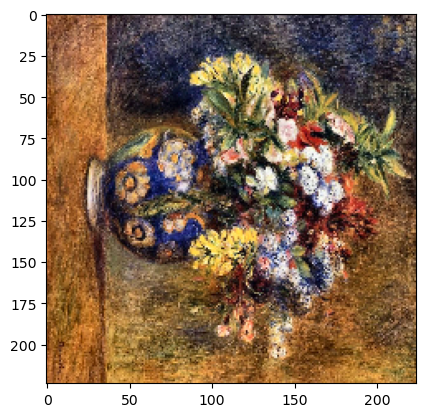

In [300]:
transform = A.Compose([
                        A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                        #A.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'], scale=(0.3, 1.0)),
                        #A.RandomGamma(gamma_limit=(80, 120)),
                        #A.CLAHE()
                        ])

transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.CLAHE(p=0.5),
                            A.RandomBrightnessContrast(p=0.2),
                            A.ColorJitter(p=0.2),
                            A.RGBShift(p=0.2),
                            A.RandomSnow(p=0.2),
                            A.HorizontalFlip(p=0.2),
                            A.VerticalFlip(p=0.2),
                            A.Rotate(p=0.2),
                            A.RandomRotate90(p=0.2),
                            A.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'], scale=(0.3, 1.0)),
                            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            #ToTensorV2(),
                            ])

import matplotlib.pyplot as plt
img_path = './train/0005.jpg'
image = cv2.imread(f"{data_dir}/{img_path.split('/')[-2]}/{img_path.split('/')[-1]}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
agumented_image = transform(image=image)['image']
plt.imshow(agumented_image)